# TimePerceiver Pre-training Pipeline for PV Forecasting (Day-ahead)


In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import os
import json
import warnings
warnings.filterwarnings('default')

import tensorflow as tf
import keras
# from keras import ops (Keras 2 compat)

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, LayerNormalization, MultiHeadAttention, Input, Embedding, Add, GlobalAveragePooling1D, Flatten
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import mlflow
import mlflow.keras
import joblib
from datetime import datetime

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

c:\Users\Lenovo\miniconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:246: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
c:\Users\Lenovo\miniconda3\envs\tf-gpu\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:326: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
c:\Users\Lenovo\miniconda3\envs\tf-gpu\lib\site-packages\mlflow\utils\requirements_utils.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa: TID251
c:\Users\Lenovo\miniconda3\envs\tf-gpu\lib\site-packages\pkg_resources\__init__.py:3146: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
I

In [ ]:
# CONFIGURATION
# Data source
CSV_PATH = r"C:\Users\Lenovo\OneDrive\Pretrain GRU\DKASC_DATA.csv"

TIME_COL = "timestamp"
TARGET_COL = "pv_output_mw"
GHI_COL = "ghi_wm2"
DHI_COL = "dhi_wm2"
TEMP_COL = "ambient_temp_c"
RH_COL = "relative_humidity_pct"
WIND_SPEED_COL = "wind_speed_ms"
WIND_DIR_COL = "wind_direction_deg"
POA_COL = "poa_global_wm2"

BASE_FEATURE_COLS = [GHI_COL, DHI_COL, TEMP_COL, RH_COL, WIND_SPEED_COL, POA_COL]

# CLEAR SKY INDEX CONFIGURATION
USE_CSI_TARGET = True
NAMEPLATE_CAPACITY_MW = 400
TEMP_COEFF = -0.0045
REF_TEMP = 25
CSI_GHI_THRESHOLD = 10
CSI_MAX = 1.2
SYSTEM_EFFICIENCY = 0.86

# MULTI-STEP FORECASTING
FORECAST_HORIZON = 24

TRAIN_RATIO = 0.70
VAL_RATIO = 0.10
TEST_RATIO = 0.20

N_TRIALS = 50
RUN_OPTUNA_TUNING = False
RUN_TSCV = True

PRESET_HYPERPARAMS = {
    'd_model': 64,
    'n_heads': 8,
    'n_layers': 2,
    'num_latents': 64,
    'dropout': 0.10348650058685432,
    'learning_rate': 0.00012630706602194145,
    'batch_size': 32,
    'lookback': 96,
    'patch_len': 24,
    'stride': 16
}
MLFLOW_EXPERIMENT_NAME = "TimePerceiver_PV_CSI_RUNNING_210127"

SAVE_DIR = r"C:\Users\Lenovo\OneDrive\Pretrain GRU\pretrained_timeperceiver_csi"

print(f"Forecast Horizon: {FORECAST_HORIZON} hours")
print(f"CSI Target: {USE_CSI_TARGET}")

Forecast Horizon: 24 hours
CSI Target: True


In [ ]:
# Load Data
print("Loading data...")
df = pd.read_csv(CSV_PATH, sep=';')
df[TIME_COL] = pd.to_datetime(df[TIME_COL], format='%d/%m/%Y %H:%M')
print(f"Original shape: {df.shape}")
print(f"Date range: {df[TIME_COL].min()} to {df[TIME_COL].max()}")
df.head()

Loading data...
Original shape: (43848, 11)
Date range: 2020-01-01 00:00:00 to 2024-12-31 23:00:00


,timestamp,pv_output_mw,ghi_wm2,dhi_wm2,ambient_temp_c,relative_humidity_pct,wind_direction_deg,daily_rainfall_mm,poa_global_wm2,poa_diffuse_wm2,wind_speed_ms
0,2020-01-01 00:00:00,0.0,1.571283,1.428369,29.117028,22.441755,33.467712,0.0,3.377401,0.865803,4.65
1,2020-01-01 01:00:00,0.0,2.127492,1.883685,27.380810,24.960477,34.147002,0.0,3.677853,1.071591,3.64
2,2020-01-01 02:00:00,0.0,1.252475,1.089047,25.768856,27.437320,34.772390,0.0,2.989562,0.672434,3.10
3,2020-01-01 03:00:00,0.0,1.764794,1.479063,24.703431,29.076403,35.148765,0.0,3.510922,0.921584,3.19
4,2020-01-01 04:00:00,0.0,1.570515,1.299423,23.439189,31.236451,35.634271,0.0,3.263593,0.652341,3.10


## 1. Data Preprocessing

In [ ]:
# Fungsi Preprocessing Algorithm
def preprocess_algorithm1_fixed(df: pd.DataFrame) -> pd.DataFrame:
 
    df = df.copy()
    print("="*60)
    print("ALGORITHM 1")
    print("="*60)
    
    # Outlier Detection Rules
    # 1. Parameter Fisik Ekstrem
    # 2. Inkonsistensi PV vs GHI 
    
    outlier_mask = (
        (df[GHI_COL] > 2000) | # Angka yang tidak mungkin 
        (df[TEMP_COL] < -30) |
        (df[WIND_SPEED_COL] < 0) |
        (df[RH_COL] < 0) | (df[RH_COL] > 100) |
        
        # Rule: PV 'Nol' saat GHI Terang (>200)
        ((df[TARGET_COL] <= 0) & (df[GHI_COL] > 200)) | # GHI tinggi tapi PV nol, anomali sistem
        
        # Rule: PV 'Tinggi' (>10% Kapasitas) saat GHI 'Gelap' (< Threshold CSI Cell 2) -> Sensor Error
        ((df[TARGET_COL] > 0.1 * NAMEPLATE_CAPACITY_MW) & (df[GHI_COL] < CSI_GHI_THRESHOLD))
    )
    
    # Hapus data non-zero yang terus-menerus sama pada 10 jam berturut-turut
    is_nonzero = df[TARGET_COL] > 0
    consecutive_same = (df[TARGET_COL] == df[TARGET_COL].shift(1)) & is_nonzero
    consecutive_count = consecutive_same.astype(int).groupby((consecutive_same != consecutive_same.shift()).cumsum()).cumsum()
    outlier_mask = outlier_mask | (consecutive_count >= 10)
    
    # Set outliers to NaN
    for col in BASE_FEATURE_COLS + [TARGET_COL]:
        df.loc[outlier_mask, col] = np.nan
    
    print(f"Outliers detected: {outlier_mask.sum()} rows ({100*outlier_mask.mean():.2f}%)")
    
    # Daily quality check - Dalam 1 hari, ada data hilang selama 2 jam berturut-turut atau lebih, hari tsb dianggap tidak representatif
    df['date'] = df[TIME_COL].dt.date
    days_to_remove = []
    for date, day_df in df.groupby('date'):
        nan_mask = day_df[TARGET_COL].isna()
        if nan_mask.any():
            consecutive_nan = nan_mask.astype(int).groupby((nan_mask != nan_mask.shift()).cumsum()).transform('sum')
            if (consecutive_nan >= 2).any():
                days_to_remove.append(date)
    
    print(f"Days removed: {len(days_to_remove)}")
    df = df[~df['date'].isin(days_to_remove)]
    
    # Interpolasi Linear - ada data hilang selama 1 jam saja, nilainya diisi dengan interpolasi linear
    for col in BASE_FEATURE_COLS + [TARGET_COL]:
        df[col] = df[col].interpolate(method='linear', limit=1) 
    
    df = df.dropna(subset=BASE_FEATURE_COLS + [TARGET_COL])
    df = df.drop(columns=['date']).reset_index(drop=True)
    
    print(f"Final: {len(df)} rows ({100*len(df)/43848:.1f}% retained)")
    print("="*60)
    return df
df_clean = preprocess_algorithm1_fixed(df)

ALGORITHM 1: DATA PRE-PROCESSING (REFACTORED)
Outliers detected: 874 rows (1.99%)
Days removed: 160
Final: 39105 rows (89.2% retained)


## 2. Feature Engineering

In [ ]:
# 1. Fungsi Kalkulasi Clear Sky PV Output

def calculate_clear_sky_pv(ghi, poa, temp_ambient, wind_speed=None, 
                           nameplate_capacity=NAMEPLATE_CAPACITY_MW,
                           temp_coeff=TEMP_COEFF,
                           ref_temp=REF_TEMP,
                           system_efficiency=SYSTEM_EFFICIENCY):  
    """
    Hitung estimasi PV output pada kondisi clear sky menggunakan formula PVWatts.
        Referensi:
    - PVWatts Version 5 Manual, NREL
    - Dobos, A. P. (2014). PVWatts version 5 manual. NREL Technical Report.
    """
    # Gunakan POA jika tersedia (>0), kalau tidak gunakan GHI
    irradiance = np.where(poa > 0, poa, ghi)
    
    # Estimasi temperature sel 
    if wind_speed is not None:
        cell_temp = temp_ambient + 0.035 * irradiance - 0.75 * np.maximum(wind_speed, 0)
    else:
        cell_temp = temp_ambient + 0.035 * irradiance
    
    # Temperature derating factor
    temp_factor = 1 + temp_coeff * (cell_temp - ref_temp)
    temp_factor = np.clip(temp_factor, 0.5, 1.2)
    
    # Clear sky PV output (MW) Model PVWatts Version 5, dengan tambahan system efficiency
    clear_sky_pv = (irradiance / 1000) * nameplate_capacity * temp_factor * system_efficiency
    clear_sky_pv = np.maximum(clear_sky_pv, 0)
    
    return clear_sky_pv

# 2. Fungsi Kalkulasi Clear Sky Index (CSI)
def calculate_csi(pv_actual, pv_clear_sky, ghi, ghi_threshold=CSI_GHI_THRESHOLD, csi_max=CSI_MAX):
    """
    Hitung Clear Sky Index (CSI) = rasio PV output aktual vs output clear sky.
    
    CSI ~ 1.0: kondisi clear sky (cerah)
    CSI < 1.0: ada awan/penghalang
    CSI > 1.0: edge-of-cloud enhancement
    """
    epsilon = 1e-6 # untuk menghindari pembagian dengan nol
    
    csi = np.where(
        (ghi > ghi_threshold) & (pv_clear_sky > epsilon),
        pv_actual / (pv_clear_sky + epsilon),
        0  # Malam hari = 0 tidak dihitung, tp jika GHI>10 maka dihitung
    )
    
    csi = np.clip(csi, 0, csi_max) # membatasi nilai CSI
    return csi

print("Clear Sky Index functions loaded.")

# 3. Fungsi Inverse CSI ke PV Output
def inverse_csi_to_pv(csi, pv_clear_sky):
    """
    Konversi Clear Sky Index (CSI) kembali ke PV output (MW).
    
    Rumus: PV_actual = CSI × PV_clear_sky
    
    Args:
        csi: Clear Sky Index (array atau scalar)
        pv_clear_sky: Estimasi PV output pada kondisi clear sky (MW)
    
    Returns:
        pv_output: PV output dalam MW
    """
    pv_output = csi * pv_clear_sky
    pv_output = np.maximum(pv_output, 0)  # Pastikan tidak negatif
    return pv_output
print("Clear Sky Index functions loaded.")

Clear Sky Index functions loaded.
Clear Sky Index functions loaded.


In [ ]:
# 2. Fungsi Ekstraksi/Pembuatan Fitur dari Fitur Awal
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    
    df = df.copy()
    if not isinstance(df.index, pd.DatetimeIndex):
        df = df.set_index(TIME_COL) # mengubah kolom time menjadi index, supaya bisa diakses dengan waktu
    
    # Simpan timestamp sebagai kolom
    df['timestamp_col'] = df.index
    
    # TEMPORAL FEATURES 
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24) # encoding siklikal
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    # ROLLING FEATURES (menghitung moving average untuk 1,3,6 jam terakhir)
    for w in [1, 3, 6]:
        df[f'ghi_ma_{w}h'] = df[GHI_COL].rolling(f'{w}h', min_periods=1).mean()
        df[f'temp_ma_{w}h'] = df[TEMP_COL].rolling(f'{w}h', min_periods=1).mean()
    
    # LAG FEATURES (mengetahui apa yang terjadi beberapa jam sebelumnya)
    df = df.sort_index()
    for lag in [1, 3, 6, 24]:
        df[f'ghi_lag_{lag}h'] = df[GHI_COL].shift(lag, freq='h')
        df[f'target_lag_{lag}h'] = df[TARGET_COL].shift(lag, freq='h')
    
    # DERIVED FEATURES 
    df['diffuse_fraction'] = (df[DHI_COL] / (df[GHI_COL] + 1e-6)).clip(0, 1)
    
    # CLEAR SKY PV OUTPUT 
    print("Calculating Clear Sky PV output...")
    df['pv_clear_sky'] = calculate_clear_sky_pv(
        ghi=df[GHI_COL].values,
        poa=df[POA_COL].values,
        temp_ambient=df[TEMP_COL].values,
        wind_speed=df[WIND_SPEED_COL].values if WIND_SPEED_COL in df.columns else None,
        nameplate_capacity=NAMEPLATE_CAPACITY_MW
    )
    
    # CSI TARGET 
    if USE_CSI_TARGET:
        print("Calculating CSI (target transformation)...")
        df['csi_target'] = calculate_csi(
            pv_actual=df[TARGET_COL].values,
            pv_clear_sky=df['pv_clear_sky'].values,
            ghi=df[GHI_COL].values,
            ghi_threshold=CSI_GHI_THRESHOLD,
            csi_max=CSI_MAX
        )
        
        # Print CSI statistics
        productive_mask = df[GHI_COL] > CSI_GHI_THRESHOLD
        print(f"  CSI stats (productive hours):")
        print(f"    Mean: {df.loc[productive_mask, 'csi_target'].mean():.4f}")
        print(f"    Std:  {df.loc[productive_mask, 'csi_target'].std():.4f}")
        print(f"    Min:  {df.loc[productive_mask, 'csi_target'].min():.4f}")
        print(f"    Max:  {df.loc[productive_mask, 'csi_target'].max():.4f}")
    
    # Kembalikan timestamp sebagai kolom (reset index)
    df = df.reset_index()
    df = df.rename(columns={'index': TIME_COL})
    
    # Drop NaN yang muncul akibat lag/rolling
    df = df.dropna().reset_index(drop=True)
    print(f"Features created. Total columns: {len(df.columns)}")
    
    return df
df_features = create_features(df_clean)

Calculating Clear Sky PV output...
Calculating CSI (target transformation)...
  CSI stats (productive hours):
    Mean: 0.7198
    Std:  0.2710
    Min:  0.0000
    Max:  1.2000
Features created. Total columns: 34


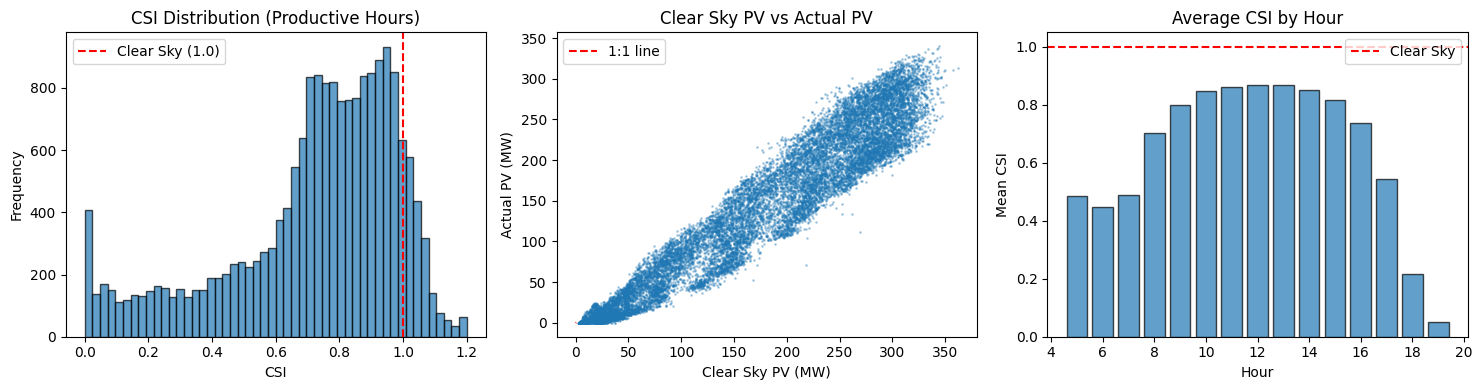

In [ ]:
# Visualize CSI distribution
if USE_CSI_TARGET:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # CSI Distribution (productive hours only)
    productive = df_features[df_features[GHI_COL] > CSI_GHI_THRESHOLD]
    axes[0].hist(productive['csi_target'], bins=50, edgecolor='black', alpha=0.7)
    axes[0].axvline(x=1.0, color='r', linestyle='--', label='Clear Sky (1.0)')
    axes[0].set_xlabel('CSI')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('CSI Distribution (Productive Hours)')
    axes[0].legend()
    
    # CSI vs PV Actual
    axes[1].scatter(productive['pv_clear_sky'], productive[TARGET_COL], alpha=0.3, s=1)
    axes[1].plot([0, 0.5], [0, 0.5], 'r--', label='1:1 line')
    axes[1].set_xlabel('Clear Sky PV (MW)')
    axes[1].set_ylabel('Actual PV (MW)')
    axes[1].set_title('Clear Sky PV vs Actual PV')
    axes[1].legend()
    
    # CSI by Hour
    csi_by_hour = productive.groupby('hour')['csi_target'].mean()
    axes[2].bar(csi_by_hour.index, csi_by_hour.values, edgecolor='black', alpha=0.7)
    axes[2].axhline(y=1.0, color='r', linestyle='--', label='Clear Sky')
    axes[2].set_xlabel('Hour')
    axes[2].set_ylabel('Mean CSI')
    axes[2].set_title('Average CSI by Hour')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()

## 3. Feature Selection

In [ ]:
# Fungsi memilih fitur (Fiture dengan korelasi lemah (< 0.05) dibuang)
def select_features_hybrid(df, target_col, corr_threshold=0.05, multicol_threshold=0.95):
    """Hybrid Feature Selection: Statistical + Domain Knowledge"""
    exclude_cols = [TIME_COL, target_col, 'pv_clear_sky', 'csi_target', TARGET_COL]
    feature_cols = [c for c in df.columns if c not in exclude_cols 
                    and df[c].dtype in ['float64', 'float32', 'int64', 'int32']]
    
    # 1. Menghitung hubungan statistik (korelasi pearson) antara fitur dengan target
    correlations = df[feature_cols].corrwith(df[target_col]).abs().sort_values(ascending=False)
    print("Top 15 Features by Correlation")
    print(correlations.head(15).to_string())
    
    selected = correlations[correlations >= corr_threshold].index.tolist()
    print(f"\nStatistically selected: {len(selected)} features")
    
    # 2. Menghapus multikolinieritas (menghapus 2 fitur yang isinya hampir sama)
    if len(selected) > 1:
        corr_matrix = df[selected].corr().abs()
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = set()
        for col in upper_tri.columns:
            high_corr = upper_tri.index[upper_tri[col] > multicol_threshold].tolist()
            for hc in high_corr:
                to_drop.add(hc if correlations[col] >= correlations[hc] else col)
        selected = [f for f in selected if f not in to_drop]
        print(f"After removing multicollinearity: {len(selected)} features")
    
    # 3. PHYSICS-BASED FEATURES (menambahkan fitur fisika asli meski korelasi kurang tinggi)
    PHYSICS_FEATURES = ['ambient_temp_c', 'relative_humidity_pct', 'wind_speed_ms']
    
    print("\n=== Adding Physics-Based Features ===")
    for feat in PHYSICS_FEATURES:
        if feat in df.columns and feat not in selected:
            corr_val = correlations.get(feat, 0)
            selected.append(feat)
            print(f"  + {feat} (corr: {corr_val:.4f}) - Physics important")
        elif feat in selected:
            print(f"  ✓ {feat} already selected")
    
    print(f"\n=== FINAL: {len(selected)} features selected ===")
    
    correlation_df = pd.DataFrame({
        'feature': selected,
        'correlation': [correlations.get(f, 0) for f in selected],
        'type': ['physics' if f in PHYSICS_FEATURES else 'statistical' for f in selected]
    }).sort_values('correlation', ascending=False)
    
    return selected, correlation_df

# Select features based on the actual target (CSI or PV output)
ACTUAL_TARGET_COL = 'csi_target' if USE_CSI_TARGET else TARGET_COL
print(f">>> Selecting features based on: {ACTUAL_TARGET_COL}")

SELECTED_FEATURES, correlation_df = select_features_hybrid(df_features, ACTUAL_TARGET_COL)
print(f"\nFeatures: {SELECTED_FEATURES}")
print("\n" + correlation_df.to_string(index=False))

>>> Selecting features based on: csi_target
Top 15 Features by Correlation
hour_cos            0.886865
target_lag_24h      0.873817
ghi_lag_24h         0.872895
ghi_wm2             0.871298
ghi_ma_1h           0.871298
poa_global_wm2      0.850806
ghi_ma_3h           0.839237
target_lag_1h       0.827482
ghi_lag_1h          0.826403
poa_diffuse_wm2     0.730668
dhi_wm2             0.699765
ghi_ma_6h           0.684130
diffuse_fraction    0.651742
ghi_lag_3h          0.564964
target_lag_3h       0.559200

Statistically selected: 23 features
After removing multicollinearity: 12 features

=== Adding Physics-Based Features ===
  + ambient_temp_c (corr: 0.5424) - Physics important
  ✓ relative_humidity_pct already selected
  ✓ wind_speed_ms already selected

=== FINAL: 13 features selected ===

Features: ['hour_cos', 'target_lag_24h', 'ghi_ma_1h', 'ghi_ma_3h', 'poa_diffuse_wm2', 'ghi_ma_6h', 'diffuse_fraction', 'temp_ma_1h', 'relative_humidity_pct', 'wind_speed_ms', 'hour', 'target_lag_6h'

## 4. Data Preparation 

In [ ]:
# DATA PREPARATION

print("="*60)
print("DATA PREPARATION")
print("="*60)
print(f"Target: {ACTUAL_TARGET_COL} ({'CSI' if USE_CSI_TARGET else 'Direct PV'})")

# Prepare features and target
X = df_features[SELECTED_FEATURES].values.astype(np.float32)
y = df_features[ACTUAL_TARGET_COL].values.astype(np.float32)

# Store original PV values for evaluation (inverse transform)
pv_clear_sky_all = df_features['pv_clear_sky'].values.astype(np.float32)
pv_actual_all = df_features[TARGET_COL].values.astype(np.float32)

# Scale data (Split First, Then Scale)
# 1. Split Raw Data 
train_size = int(TRAIN_RATIO * len(X))
# (We don't strictly need val/test sizes here for fitting, just train)

X_train_raw = X[:train_size]
y_train_raw = y[:train_size]

# 2. Scaling hanya pada data training
print(f"Fitting scalers on training data (first {train_size} samples)...")
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_scaler.fit(X_train_raw)
y_scaler.fit(y_train_raw.reshape(-1, 1))

# 3. Membuat sequence (mengubah data dari 2D menjadi 3D)
X_scaled = X_scaler.transform(X)
y_scaled = y_scaler.transform(y.reshape(-1, 1)).flatten()

def create_sequences(X, y, lookback, horizon=1):
    """Create sequences for multi-step forecasting."""
    Xs, ys = [], []
    for i in range(lookback, len(X) - horizon + 1):
        Xs.append(X[i-lookback:i])
        ys.append(y[i:i+horizon] if horizon > 1 else y[i])
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)

def create_sequences_with_indices(X, y, lookback, horizon=1):
    """Create sequences and return indices for inverse transform."""
    Xs, ys, indices = [], [], []
    for i in range(lookback, len(X) - horizon + 1):
        Xs.append(X[i-lookback:i])
        ys.append(y[i:i+horizon] if horizon > 1 else y[i])
        indices.append(list(range(i, i+horizon)))
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32), np.array(indices)

print(f"X_scaled: {X_scaled.shape}, y_scaled: {y_scaled.shape}")
print(f"Forecast horizon: {FORECAST_HORIZON} hours")
print(f"y range: [{y_scaled.min():.4f}, {y_scaled.max():.4f}]")
print("="*60)

def build_sequences(X, y, lookback, horizon):
    Xs, ys = [], []
    for i in range(lookback, len(X) - horizon + 1):
        Xs.append(X[i-lookback:i])
        ys.append(y[i:i+horizon])
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32), None



DATA PREPARATION
Target: csi_target (CSI)
Fitting scalers on training data (first 26199 samples)...
X_scaled: (37428, 13), y_scaled: (37428,)
Forecast horizon: 24 hours
y range: [0.0000, 1.0000]


## 5. Hyperparameter Tuning 

In [ ]:
# TimePerceiver (Encoder-Decoder Transformer) (arXiv:2206.12643)
import mlflow
import mlflow.keras
from keras.layers import Dense, Dropout, LayerNormalization, MultiHeadAttention, Input, Embedding, Flatten, GlobalAveragePooling1D

# --- CUSTOM LAYERS FOR TIME PERCEIVER ---

class PatchingLayer(tf.keras.layers.Layer):
    def __init__(self, patch_len, stride, **kwargs):
        super().__init__(**kwargs)
        self.patch_len = patch_len
        self.stride = stride

    def call(self, x):
        x = tf.transpose(x, [0, 2, 1])
        patches = tf.image.extract_patches(
            images=tf.expand_dims(x, axis=-1),
            sizes=[1, 1, self.patch_len, 1],
            strides=[1, 1, self.stride, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        return patches

class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, num_patches, d_model, **kwargs):
        super().__init__(**kwargs)
        self.pos_emb = Embedding(input_dim=num_patches, output_dim=d_model)

    def call(self, x):
        num_patches = tf.shape(x)[1]
        positions = tf.range(num_patches)
        return x + self.pos_emb(positions)

class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.mha = MultiHeadAttention(num_heads=n_heads, key_dim=d_model // n_heads)
        self.ln = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(dropout)

    def call(self, q, kv, training=False):
        attn_out = self.mha(query=q, value=kv, key=kv, training=training)
        return self.ln(q + self.dropout(attn_out, training=training))

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, ff_dim, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.mha = MultiHeadAttention(num_heads=n_heads, key_dim=d_model // n_heads)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="gelu"),
            Dense(d_model),
        ])
        self.ln1 = LayerNormalization(epsilon=1e-6)
        self.ln2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

    def call(self, x, training=False):
        attn_output = self.mha(query=x, value=x, key=x, training=training)
        x = self.ln1(x + self.dropout1(attn_output, training=training))
        ffn_output = self.ffn(x, training=training)
        return self.ln2(x + self.dropout2(ffn_output, training=training))

class PerceiverEncoder(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, num_latents, n_layers, **kwargs):
        super().__init__(**kwargs)
        self.num_latents = num_latents
        self.d_model = d_model
        self.cross_attn = CrossAttention(d_model, n_heads)
        self.self_attn_layers = [TransformerBlock(d_model, n_heads, d_model*4) for _ in range(n_layers)]

    def build(self, input_shape):
        self.latent_array = self.add_weight(
            name="latents",
            shape=(self.num_latents, self.d_model),
            initializer="random_normal",
            trainable=True
        )

    def call(self, x, training=False):
        batch_size = tf.shape(x)[0]
        latents = tf.broadcast_to(self.latent_array, (batch_size, self.num_latents, self.d_model))
        
        # Latent Bottleneck: Cross-Attend Latents to Input
        x = self.cross_attn(latents, x, training=training)
        
        # Refinement: Self-Attention on Latents
        for layer in self.self_attn_layers:
            x = layer(x, training=training)
        return x

class PerceiverDecoder(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, forecast_horizon, **kwargs):
        super().__init__(**kwargs)
        self.forecast_horizon = forecast_horizon
        self.d_model = d_model
        self.cross_attn = CrossAttention(d_model, n_heads)
        
    def build(self, input_shape):
        self.query_array = self.add_weight(
            name="queries",
            shape=(self.forecast_horizon, self.d_model),
            initializer="random_normal",
            trainable=True
        )

    def call(self, latents, training=False):
        batch_size = tf.shape(latents)[0]
        queries = tf.broadcast_to(self.query_array, (batch_size, self.forecast_horizon, self.d_model))
        
        # Decode: Cross-Attend Queries to Latents
        x = self.cross_attn(queries, latents, training=training)
        return x

def build_timeperceiver(lookback, n_features, forecast_horizon, d_model, n_heads, n_layers, num_latents, patch_len, stride, dropout):
    inputs = Input(shape=(lookback, n_features))
    
    # 1. Patching: (B, L, F) -> (B, F, N, P)
    patches = PatchingLayer(patch_len, stride)(inputs)
    num_patches = patches.shape[2]
    
    # 2. Linear Projection + Reshape for Perceiver
    # Reshape: (B, F, N, P) -> (B, F*N, P)
    x = tf.reshape(patches, (-1, n_features * num_patches, patch_len))
    x = Dense(d_model)(x) # (B, tokens, d_model)
    
    # 3. Encoder: Input tokens -> Latent tokens
    latents = PerceiverEncoder(d_model, n_heads, num_latents, n_layers)(x)
    
    # 4. Decoder: Queries (horizon) -> Decoded tokens
    decoded = PerceiverDecoder(d_model, n_heads, forecast_horizon)(latents)
    
    # 5. Output Head
    x = Flatten()(decoded)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout)(x)
    outputs = Dense(forecast_horizon)(x)
    
    return tf.keras.Model(inputs, outputs)

# --- OPTUNA OBJECTIVE ---

def objective(trial):
    d_model = trial.suggest_categorical('d_model', [64, 128])
    n_heads = trial.suggest_categorical('n_heads', [4, 8])
    n_layers = trial.suggest_int('n_layers', 2, 4)
    num_latents = trial.suggest_categorical('num_latents', [16, 32, 64])
    patch_len = trial.suggest_categorical('patch_len', [8, 16, 24])
    stride = trial.suggest_categorical('stride', [8, 16])
    dropout = trial.suggest_float('dropout', 0.1, 0.3)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 5e-4, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    lookback = trial.suggest_int('lookback', 48, 192, step=48)

    if lookback < patch_len:
        return 1e9 # Invalid trial

    X_seq, y_seq, _ = build_sequences(X_scaled, y_scaled, lookback, FORECAST_HORIZON)
    n_train_seq = int(0.8 * len(X_seq))
    X_train_seq, y_train_seq = X_seq[:n_train_seq], y_seq[:n_train_seq]
    X_val_seq, y_val_seq = X_seq[n_train_seq:], y_seq[n_train_seq:]
    
    model = build_timeperceiver(
        lookback=lookback,
        n_features=len(SELECTED_FEATURES),
        forecast_horizon=FORECAST_HORIZON,
        d_model=d_model,
        n_heads=n_heads,
        n_layers=n_layers,
        num_latents=num_latents,
        patch_len=patch_len,
        stride=stride,
        dropout=dropout
    )
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=40,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )
    
    val_loss = min(history.history['val_loss'])
    with mlflow.start_run(nested=True):
        mlflow.log_params(trial.params)
        mlflow.log_metric('val_loss', val_loss)
    
    return val_loss


In [ ]:
# --- RUN OPTUNA TUNING ---
if RUN_OPTUNA_TUNING:
    print("Starting Hyperparameter Tuning with Optuna...")
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=N_TRIALS)
    
    best = study.best_params
    print("\n" + "="*30)
    print("TUNING COMPLETE!")
    print(f"Best Val Loss: {study.best_value:.6f}")
    print(f"Best Params: {best}")
    print("="*30)
else:
    print("RUN_OPTUNA_TUNING is False. Using PRESET_HYPERPARAMS.")
    best = PRESET_HYPERPARAMS


RUN_OPTUNA_TUNING is False. Using PRESET_HYPERPARAMS.


## 6. Train Final Model

In [ ]:
# Final Training with TimePerceiver
print(f"Final Model: TimePerceiver (arXiv:2505.15151)")
if 'best' not in locals():
    best = PRESET_HYPERPARAMS
LOOKBACK_BEST = best['lookback']

# Sequences
X_seq, y_seq, seq_indices = create_sequences_with_indices(X_scaled, y_scaled, LOOKBACK_BEST, FORECAST_HORIZON)
n_train = int(0.7 * len(X_seq))
n_val = int(0.1 * len(X_seq))
X_train, y_train = X_seq[:n_train], y_seq[:n_train]
X_val, y_val = X_seq[n_train:n_train+n_val], y_seq[n_train:n_train+n_val]
X_test, y_test = X_seq[n_train+n_val:], y_seq[n_train+n_val:]

# Build with Patching Params
best_model = build_timeperceiver(
    lookback=LOOKBACK_BEST,
    n_features=len(SELECTED_FEATURES),
    forecast_horizon=FORECAST_HORIZON,
    d_model=best['d_model'],
    n_heads=best['n_heads'],
    n_layers=best['n_layers'],
    num_latents=best['num_latents'],
    patch_len=best['patch_len'],
    stride=best['stride'],
    dropout=best['dropout']
)

best_model.compile(optimizer=Adam(learning_rate=best['learning_rate']), loss='mse')
best_model.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=100, batch_size=best['batch_size'], callbacks=callbacks, verbose=1)


Final Model: TimePerceiver (arXiv:2505.15151)


c:\Users\Lenovo\miniconda3\envs\tf-gpu\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 13)]          0         
                                                                 
 patching_layer (PatchingLay  (None, 13, 5, 24)        0         
 er)                                                             
                                                                 
 tf.reshape (TFOpLambda)     (None, 65, 24)            0         
                                                                 
 dense (Dense)               (None, 65, 64)            1600      
                                                                 
 perceiver_encoder (Perceive  (None, 64, 64)           120832    
 rEncoder)                                                       
                                                                 
 perceiver_decoder (Perceive  (None, 24, 64)           18304 

## 7. Evaluation 

In [ ]:
# EVALUATION WITH ROBUST MULTI-STEP CONSISTENCY 
def apply_physical_constraints(pv_pred, ghi_values, threshold=10):
    """Apply physical constraints to PV predictions across all steps."""
    pv_pred = np.clip(pv_pred, 0, None)

    # Set output to 0 if GHI is below threshold (Night/Very Low Light)
    pv_pred = np.where(ghi_values < threshold, 0, pv_pred)
    return pv_pred
def calculate_full_metrics(y_true_all, y_pred_all, ghi_all=None, set_name="SET"):
    """Calculate metrics focusing on productive hours (GHI > 50)."""
    maes, rmses, r2s, mapes = [], [], [], []
    
    # Calculate global metrics for each horizon step
    for i in range(FORECAST_HORIZON):
        y_true = y_true_all[:, i]
        y_pred = y_pred_all[:, i]
        
        maes.append(mean_absolute_error(y_true, y_pred))
        rmses.append(np.sqrt(mean_squared_error(y_true, y_pred)))
        r2s.append(r2_score(y_true, y_pred))
        
        mask = y_true > 0.001
        if mask.any():
            mapes.append(np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100)
        else:
            mapes.append(0)
            
    mae_all, rmse_all, r2_all, mape_all = np.mean(maes), np.mean(rmses), np.mean(r2s), np.mean(mapes)
    
    # PRODUCTIVE HOURS FILTER (GHI > 50)
    p_mae, p_rmse, p_r2, p_mape = 0, 0, 0, 0
    if ghi_all is not None:
        prod_mask = ghi_all > 50
        if prod_mask.any():
            y_t_p = y_true_all[prod_mask]
            y_p_p = y_pred_all[prod_mask]
            
            p_mae = mean_absolute_error(y_t_p, y_p_p)
            p_rmse = np.sqrt(mean_squared_error(y_t_p, y_p_p))
            p_r2 = r2_score(y_t_p, y_p_p)
            
            nz_mask = y_t_p > 0.001
            p_mape = np.mean(np.abs((y_t_p[nz_mask] - y_p_p[nz_mask]) / y_t_p[nz_mask])) * 100 if nz_mask.any() else 0
            
            print(f"\n>>> {set_name} - PRODUCTIVE HOURS (GHI > 50) <<<")
            print(f"  MAE:  {p_mae:.4f} MW")
            print(f"  RMSE: {p_rmse:.4f} MW")
            print(f"  R²:   {p_r2:.4f}")
            print(f"  MAPE: {p_mape:.2f}%")
        else:
            print(f"\n!!! {set_name} - NO PRODUCTIVE HOURS (GHI > 50) FOUND !!!")
            
    return mae_all, rmse_all, r2_all, mape_all, p_mae, p_rmse, p_r2, p_mape
print("="*70)
print("FINAL EVALUATION: PRODUCTIVE HOURS FOCUS")
print("="*70)
print(f"Forecast Horizon: {FORECAST_HORIZON} hours")
print(f"Train Samples: {X_train.shape[0]}, Test Samples: {X_test.shape[0]}")

# TRAIN PREDICTION 
print("\nPredicting on Train Set...")
train_pred_scaled = best_model.predict(X_train, verbose=0)
train_pred_inv = y_scaler.inverse_transform(train_pred_scaled)
train_actual_inv = y_scaler.inverse_transform(y_train)
train_idx_2d = seq_indices[:n_train].astype(int)
pv_clear_sky_train = pv_clear_sky_all[train_idx_2d]
ghi_train = df_features[GHI_COL].values[train_idx_2d]
if USE_CSI_TARGET:
    pv_train_pred = train_pred_inv * pv_clear_sky_train
    pv_train_actual = train_actual_inv * pv_clear_sky_train
else:
    pv_train_pred = train_pred_inv
    pv_train_actual = train_actual_inv
pv_train_pred = apply_physical_constraints(pv_train_pred, ghi_train)
_ = calculate_full_metrics(pv_train_actual, pv_train_pred, ghi_train, "TRAIN SET")

# TEST PREDICTION
print("\nPredicting on Test Set...")
test_pred_scaled = best_model.predict(X_test, verbose=0)
test_pred_inv = y_scaler.inverse_transform(test_pred_scaled)
test_actual_inv = y_scaler.inverse_transform(y_test)
test_idx_2d = seq_indices[n_train + n_val:].astype(int)
pv_clear_sky_test = pv_clear_sky_all[test_idx_2d]
ghi_test = df_features[GHI_COL].values[test_idx_2d]
if USE_CSI_TARGET:
    pv_test_pred = test_pred_inv * pv_clear_sky_test
    pv_test_actual = test_actual_inv * pv_clear_sky_test
else:
    pv_test_pred = test_pred_inv
    pv_test_actual = test_actual_inv
pv_test_pred = apply_physical_constraints(pv_test_pred, ghi_test)

# Assign to global variables for MLflow logging and Model Saving 
mae_eval, rmse_eval, r2_eval, mape_eval, \
mae_prod_eval, rmse_prod_eval, r2_prod_eval, mape_prod_eval = \
    calculate_full_metrics(pv_test_actual, pv_test_pred, ghi_test, "TEST SET")

FINAL EVALUATION: PRODUCTIVE HOURS FOCUS
Forecast Horizon: 24 hours
Train Samples: 26116, Test Samples: 7463

Predicting on Train Set...

>>> TRAIN SET - PRODUCTIVE HOURS (GHI > 50) <<<
  MAE:  8.8794 MW
  RMSE: 14.0762 MW
  R²:   0.9754
  MAPE: 11.13%

Predicting on Test Set...

>>> TEST SET - PRODUCTIVE HOURS (GHI > 50) <<<
  MAE:  11.4381 MW
  RMSE: 16.7359 MW
  R²:   0.9598
  MAPE: 17.84%


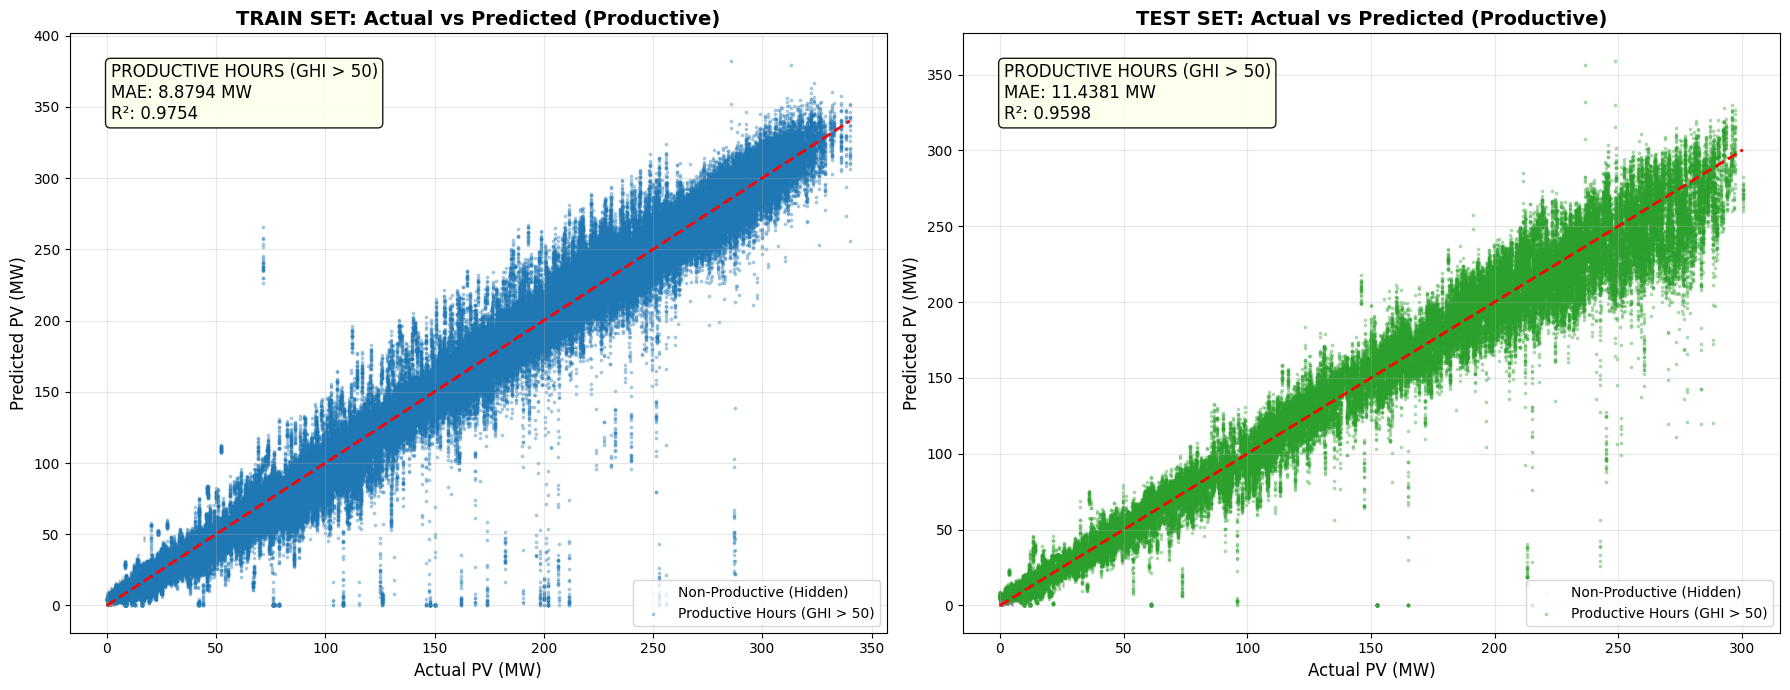

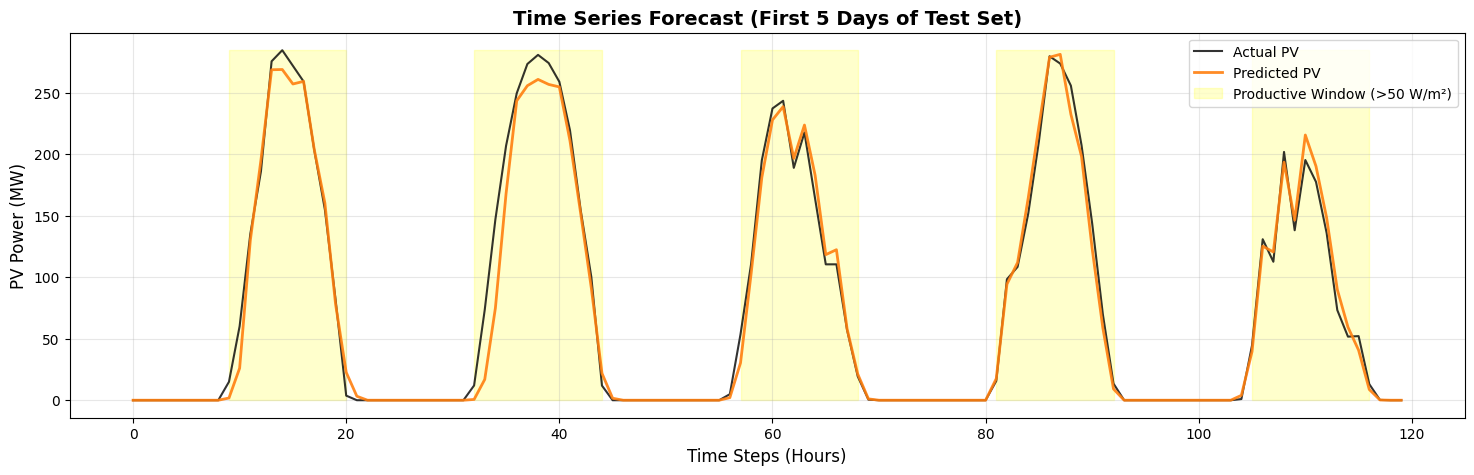

In [ ]:
# VISUALIZATION: ACTUAL VS PREDICTED (PRODUCTIVE HOURS FOCUS)
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# 1. Prepare Flattened Data
pv_train_actual_flat = pv_train_actual.flatten()
pv_train_pred_flat = pv_train_pred.flatten()
ghi_train_flat = ghi_train.flatten()

pv_test_actual_flat = pv_test_actual.flatten()
pv_test_pred_flat = pv_test_pred.flatten()
ghi_test_flat = ghi_test.flatten()

# 2. Metric Calculation Helper (Productive Hours Only)
def calc_prod_metrics(y_true_all, y_pred_all, ghi_all):
    # Productive: Filter GHI > 50
    mask = ghi_all > 50
    if mask.any():
        mae_prod = mean_absolute_error(y_true_all[mask], y_pred_all[mask])
        r2_prod = r2_score(y_true_all[mask], y_pred_all[mask])
    else:
        mae_prod, r2_prod = 0.0, 0.0
    return mae_prod, r2_prod

# Calculate Metrics
tr_mae_p, tr_r2_p = calc_prod_metrics(pv_train_actual, pv_train_pred, ghi_train)
ts_mae_p, ts_r2_p = calc_prod_metrics(pv_test_actual, pv_test_pred, ghi_test)

# Text Generator (Only Productive)
def make_text(mae_p, r2_p):
    return (f'PRODUCTIVE HOURS (GHI > 50)\n'
            f'MAE: {mae_p:.4f} MW\n'
            f'R²: {r2_p:.4f}')

train_text = make_text(tr_mae_p, tr_r2_p)
test_text = make_text(ts_mae_p, ts_r2_p)

# 3. Plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# TRAIN PLOT
# Plot background (non-productive) very faintly
mask_np_train = ghi_train_flat <= 50
axes[0].scatter(pv_train_actual_flat[mask_np_train], pv_train_pred_flat[mask_np_train], 
                alpha=0.05, s=1, color='gray', label='Non-Productive (Hidden)')
# Plot Productive Hours prominently
mask_p_train = ghi_train_flat > 50
axes[0].scatter(pv_train_actual_flat[mask_p_train], pv_train_pred_flat[mask_p_train], 
                alpha=0.3, s=3, color='#1f77b4', label='Productive Hours (GHI > 50)')

axes[0].plot([0, pv_train_actual_flat.max()], [0, pv_train_actual_flat.max()], 'r--', lw=2)
axes[0].set_title('TRAIN SET: Actual vs Predicted (Productive)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Actual PV (MW)', fontsize=12)
axes[0].set_ylabel('Predicted PV (MW)', fontsize=12)
axes[0].legend(loc='lower right')
axes[0].text(0.05, 0.95, train_text, transform=axes[0].transAxes, fontsize=12, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='#ffffed', alpha=0.9))
axes[0].grid(True, alpha=0.3)

# TEST PLOT
# Plot background (non-productive) very faintly
mask_np_test = ghi_test_flat <= 50
axes[1].scatter(pv_test_actual_flat[mask_np_test], pv_test_pred_flat[mask_np_test], 
                alpha=0.05, s=1, color='gray', label='Non-Productive (Hidden)')
# Plot Productive Hours prominently
mask_p_test = ghi_test_flat > 50
axes[1].scatter(pv_test_actual_flat[mask_p_test], pv_test_pred_flat[mask_p_test], 
                alpha=0.3, s=3, color='#2ca02c', label='Productive Hours (GHI > 50)')

axes[1].plot([0, pv_test_actual_flat.max()], [0, pv_test_actual_flat.max()], 'r--', lw=2)
axes[1].set_title('TEST SET: Actual vs Predicted (Productive)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Actual PV (MW)', fontsize=12)
axes[1].set_ylabel('Predicted PV (MW)', fontsize=12)
axes[1].legend(loc='lower right')
axes[1].text(0.05, 0.95, test_text, transform=axes[1].transAxes, fontsize=12, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='#ffffed', alpha=0.9))
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Time Series (First 5 Days)
plt.figure(figsize=(18, 5))
plt.plot(pv_test_actual[:120, 0], label='Actual PV', color='black', lw=1.5, alpha=0.8)
plt.plot(pv_test_pred[:120, 0], label='Predicted PV', color='#ff7f0e', lw=2, alpha=0.9)
# Highlight Productive Windows
plt.fill_between(range(120), 0, pv_test_actual[:120, 0].max(), 
                 where=(ghi_test[:120, 0] > 50), color='yellow', alpha=0.2, label='Productive Window (>50 W/m²)')

plt.title('Time Series Forecast (First 5 Days of Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Time Steps (Hours)', fontsize=12)
plt.ylabel('PV Power (MW)', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

## 8. Save Model and Artifacts

In [ ]:
# SAVE MODEL, SCALERS, AND CONFIGURATION
import json
import os

# 1. Tentukan lokasi simpan (jika belum ada)
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)
    print(f"Created directory: {SAVE_DIR}")

# 2. Simpan Model (.keras)
model_path = os.path.join(SAVE_DIR, 'timeperceiver_csi_model.keras')
best_model.save(model_path)
print(f"Model saved: {model_path}")

# 3. Simpan Scalers (.pkl)
import joblib
joblib.dump(X_scaler, os.path.join(SAVE_DIR, 'X_scaler.pkl'))
joblib.dump(y_scaler, os.path.join(SAVE_DIR, 'y_scaler.pkl'))
print("Scalers saved.")

# 4. Pastikan variabel metrik sudah ada (Gunakan hasil dari Cell 7)
# Jika secara tidak sengaja variabel belum terdefinisi, kita panggil fungsi evaluasinya di sini
try:
    _ = mae_eval 
except NameError:
    print("Metrics not found in memory, re-calculating for saving...")
    mae_eval, rmse_eval, r2_eval, mape_eval, mae_prod_eval, rmse_prod_eval, r2_prod_eval, mape_prod_eval = \
        calculate_full_metrics(pv_test_actual, pv_test_pred, ghi_test, "TEST SET")

# 5. Helper untuk convert tipe data NumPy agar bisa masuk JSON
def convert_numpy(obj):
    if isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, dict):
        return {k: convert_numpy(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [convert_numpy(i) for i in obj]
    return obj
    
# 6. Simpan Konfigurasi & Metrik ke JSON
config = {
    'features': SELECTED_FEATURES,
    'forecast_horizon': FORECAST_HORIZON,
    'lookback': LOOKBACK_BEST,
    'use_csi_target': USE_CSI_TARGET,
    'nameplate_capacity_mw': NAMEPLATE_CAPACITY_MW,
    'temp_coeff': TEMP_COEFF,
    'ref_temp': REF_TEMP,
    'csi_ghi_threshold': CSI_GHI_THRESHOLD,
    'csi_max': CSI_MAX,
    'best_params': best,
    'metrics': {
        'overall': {
            'mae': float(mae_eval), 
            'rmse': float(rmse_eval), 
            'r2': float(r2_eval), 
            'mape': float(mape_eval)
        },
        'productive_hours': {
            'mae': float(mae_prod_eval), 
            'rmse': float(rmse_prod_eval), 
            'r2': float(r2_prod_eval), 
            'mape': float(mape_prod_eval)
        }
    }
}
with open(os.path.join(SAVE_DIR, 'config.json'), 'w') as f:
    json.dump(convert_numpy(config), f, indent=2)
print("Configuration saved to config.json")
# 7. LOG KE MLFLOW (Final Step)
print("\nLogging final model to MLflow...")
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
with mlflow.start_run(run_name="final_timetracker_moe_csi_model"):
    mlflow.log_params(convert_numpy(best))
    mlflow.log_param("forecast_horizon", FORECAST_HORIZON)
    mlflow.log_param("lookback", LOOKBACK_BEST)
    mlflow.log_param("use_csi_target", USE_CSI_TARGET)
    
    # Log Metrik Utama
    mlflow.log_metric("mae_overall", float(mae_eval))
    mlflow.log_metric("rmse_overall", float(rmse_eval))
    mlflow.log_metric("r2_overall", float(r2_eval))
    mlflow.log_metric("mape_overall", float(mape_eval))
    mlflow.log_metric("mae_productive", float(mae_prod_eval))
    mlflow.log_metric("r2_productive", float(r2_prod_eval))
    
    # Log Artifacts (Penting untuk Reproducibility)
    mlflow.log_artifact(model_path)
    mlflow.log_artifact(os.path.join(SAVE_DIR, 'X_scaler.pkl'))
    mlflow.log_artifact(os.path.join(SAVE_DIR, 'y_scaler.pkl'))
    mlflow.log_artifact(os.path.join(SAVE_DIR, 'config.json'))
    
    print(f"Logged to MLflow! Run ID: {mlflow.active_run().info.run_id}")
print("\n" + "="*70)
print("ALL ARTIFACTS SAVED SUCCESSFULLY!")
print("="*70)

In [ ]:
# EXPORT RESULTS TO CSV (WITH POST-PROCESSING)

import pandas as pd
import numpy as np

# Post-processing threshold
GHI_NIGHT_THRESHOLD = 10  # W/m²

def apply_physical_constraints(pv_pred, ghi_values, threshold=10):
    """Apply physical constraints to PV predictions."""
    pv_pred = np.clip(pv_pred, 0, None)
    pv_pred = np.where(ghi_values < threshold, 0, pv_pred)
    return pv_pred

def inverse_transform_helper(pred_scaled, actual_scaled, clear_sky_arr, scaler, use_csi):
    """Inverse scale and CSI transform (Step 0 Only)."""
    pred = scaler.inverse_transform(pred_scaled)
    actual = scaler.inverse_transform(actual_scaled)
    
    pred_flat = pred[:, 0]
    actual_flat = actual[:, 0]
    
    if use_csi:
        if clear_sky_arr.ndim > 1:
            cs_adjust = clear_sky_arr[:, 0]
        else:
            cs_adjust = clear_sky_arr   
        pred_final = pred_flat * cs_adjust
        actual_final = actual_flat * cs_adjust
    else:
        pred_final = pred_flat
        actual_final = actual_flat
        
    return pred_final, actual_final

print("Generating predictions for Export...")
train_pred_scaled = best_model.predict(X_train, verbose=0)
test_pred_scaled = best_model.predict(X_test, verbose=0)

# Get Clear Sky & GHI Data
train_indices = seq_indices[:n_train]
test_indices = seq_indices[n_train+n_val:]

pv_clr_train = np.array([pv_clear_sky_all[idx] for idx in train_indices])
pv_clr_test = np.array([pv_clear_sky_all[idx] for idx in test_indices])

ghi_train = np.array([df_features[GHI_COL].values[idx] for idx in train_indices])
ghi_test = np.array([df_features[GHI_COL].values[idx] for idx in test_indices])

# Handle multi-dimensional GHI
if ghi_train.ndim > 1:
    ghi_train = ghi_train[:, 0]
if ghi_test.ndim > 1:
    ghi_test = ghi_test[:, 0]

# Transform
pv_train_pred, pv_train_actual = inverse_transform_helper(train_pred_scaled, y_train, pv_clr_train, y_scaler, USE_CSI_TARGET)
pv_test_pred, pv_test_actual = inverse_transform_helper(test_pred_scaled, y_test, pv_clr_test, y_scaler, USE_CSI_TARGET)

# Apply post-processing
pv_train_pred = apply_physical_constraints(pv_train_pred, ghi_train, GHI_NIGHT_THRESHOLD)
pv_test_pred = apply_physical_constraints(pv_test_pred, ghi_test, GHI_NIGHT_THRESHOLD)

# Export
print("Exporting to CSV...")
timestamps_train = [df_features[TIME_COL].iloc[idx] for idx in train_indices]
timestamps_test = [df_features[TIME_COL].iloc[idx] for idx in test_indices]

df_train_export = pd.DataFrame({
    'timestamp': timestamps_train,
    'set': 'Train',
    'pv_actual': pv_train_actual,
    'pv_predicted': pv_train_pred
})

df_test_export = pd.DataFrame({
    'timestamp': timestamps_test,
    'set': 'Test',
    'pv_actual': pv_test_actual,
    'pv_predicted': pv_test_pred
})

df_final = pd.concat([df_train_export, df_test_export], axis=0)
save_path = r"C:/Users/user/Documents/PV Data Engineering (skripsi)/Pre-train model TimePerceiver/prediction_results_timeperceiver_csi.csv"
df_final.to_csv(save_path, index=False, sep=';')
print(f"SUCCESS: Results saved to {save_path}")
print(f"Post-processing applied: Negative → 0, Night (GHI<{GHI_NIGHT_THRESHOLD}) → 0")
print(df_final.head(10))
